{0: 247, 32: 282, 48: 250, 16: 245}
b=1 A=2 N=15


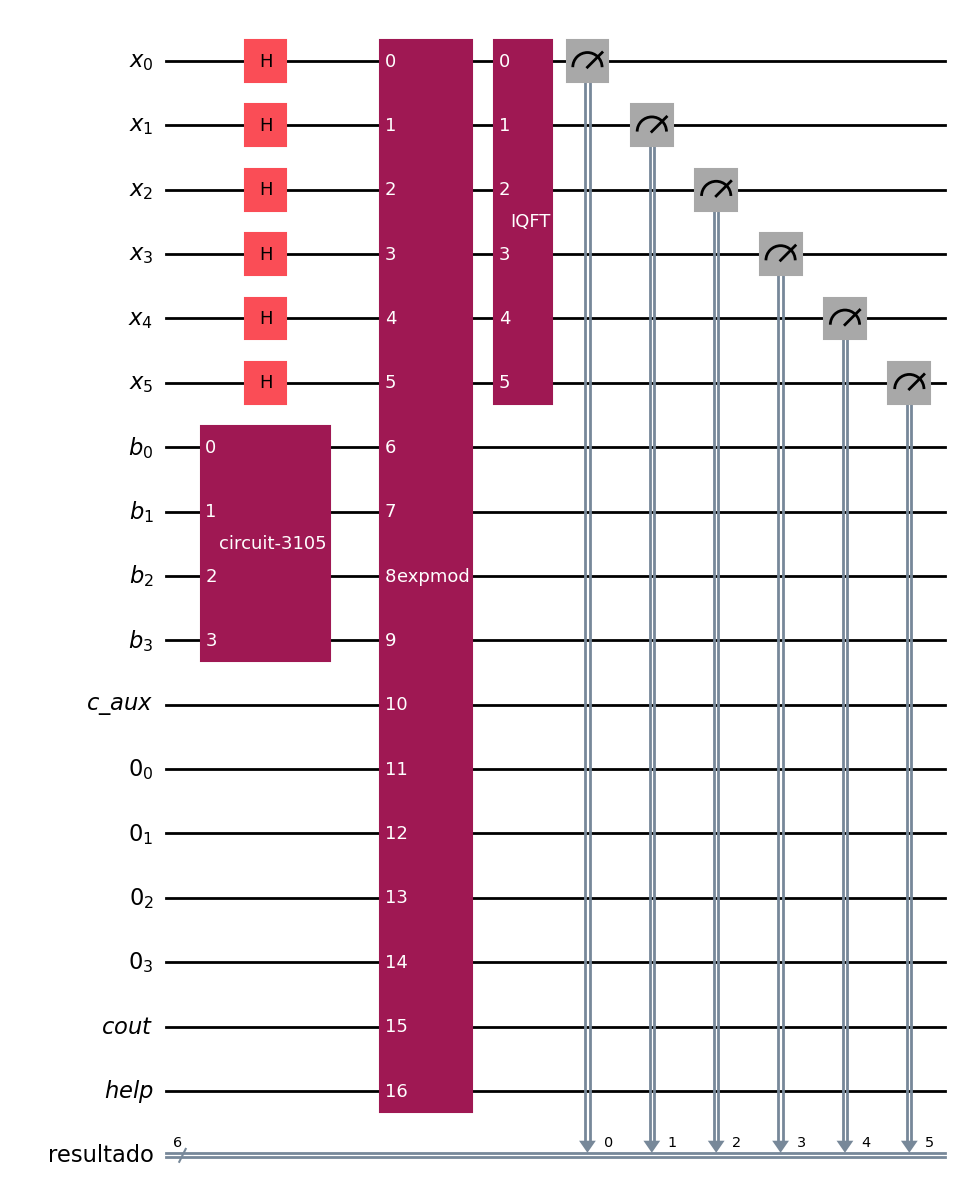

In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
from ctrl_mult_mod import ctrl_mult_mod
from math import log2


N = 15  # N = p*q; p, q primos
n_bits = int(log2(N))+1

A = 2 # Base do expoente

b = 1 # Registrador inicial da multiplicação

x_bits = 6 # q=2**x_bits, tamanho da amostra

reg_x = QuantumRegister(x_bits, "x")
number_x = QuantumCircuit(reg_x)

reg_b = QuantumRegister(n_bits, "b")
number_b = QuantumCircuit(reg_b)
number_b.initialize(b)

reg_c_aux = QuantumRegister(1, "c_aux")

reg_0 = QuantumRegister(n_bits, "0")

#reg_extra = QuantumRegister(n_bits, "ex")

reg_cout = QuantumRegister(1, "cout")

reg_help = QuantumRegister(1, "help")

reg_result = ClassicalRegister(x_bits, "resultado")

#reg_extra_result = ClassicalRegister(n_bits, "extra")

#x_bits + 3*n_bits
expmod = QuantumCircuit(reg_x, reg_b, reg_c_aux, reg_0, reg_cout, reg_help, name="expmod")

circuito = QuantumCircuit(reg_x, reg_b, reg_c_aux, reg_0, reg_cout, reg_help, reg_result)


circuito.h(reg_x)
circuito.append(number_b, reg_b)

for i in range(x_bits):
        expmod.append(ctrl_mult_mod(n_bits, (A**(2**i)) % N, N), reg_x[i:i+1] + reg_b[:] + reg_c_aux[:] + reg_0[:] + reg_cout[:] + reg_help[:])

        for j in range(N):
            if (A**(2**i) * j) % N == 1:
                a_inv = j
                break

        expmod.append(ctrl_mult_mod(n_bits, a_inv, N).inverse(), reg_x[i:i+1] + reg_0[:] + reg_c_aux[:] + reg_b[:] + reg_cout[:] + reg_help[:])

        for j in range(n_bits):
            expmod.ccx(reg_x[i], reg_b[j], reg_0[j])
            expmod.ccx(reg_x[i], reg_0[j], reg_b[j])
            expmod.ccx(reg_x[i], reg_b[j], reg_0[j])

circuito.append(expmod, reg_x[:] + reg_b[:] + reg_c_aux[:] + reg_0[:] + reg_cout[:] + reg_help[:])

#for i in range(n_bits):
#  circuito.cx(reg_b[i], reg_extra[i])

#circuito.append(expmod.inverse(), reg_x[:] + reg_b[:] + reg_c_aux[:] + reg_0[:] + reg_cout[:] + reg_help[:])

circuito.append(QFT(x_bits).inverse(), reg_x[:])
#QFT_correction(circuito, reg_x)

circuito.measure(reg_x[:], reg_result)
#circuito.measure(reg_extra, reg_extra_result)

from qiskit_aer import AerSimulator
#from qiskit_addon_aqc_tensor.simulation.aer import QiskitAerSimulationSettings
from qiskit import transpile

backend1 = AerSimulator(method="matrix_product_state")
qc1 = transpile(circuito, backend=backend1)

from qiskit.primitives import StatevectorSampler

statevectorsampler = StatevectorSampler()
pub = (qc1)
job = statevectorsampler.run([pub], shots=1024)
print(job.result()[0].data.resultado.get_int_counts())


print("b=" + str(b), "A=" + str(A), "N=" + str(N))

'''
for i in counts:
    res = f"{i:9b}".strip()
    resB = "0b0" + res[:-x_bits]
    resA = "0b" + res[-x_bits:]
    print("|x>:", eval(resA),"|b*A^x mod N>:",eval(resB), "Esperado:", str(((b*A)**eval(resA)) % N))
'''

Resultado = job.result()[0].data.resultado.get_int_counts()
for i in range(1<<(x_bits)):
  if i not in Resultado:
    Resultado[i] = 1

circuito.draw("mpl")

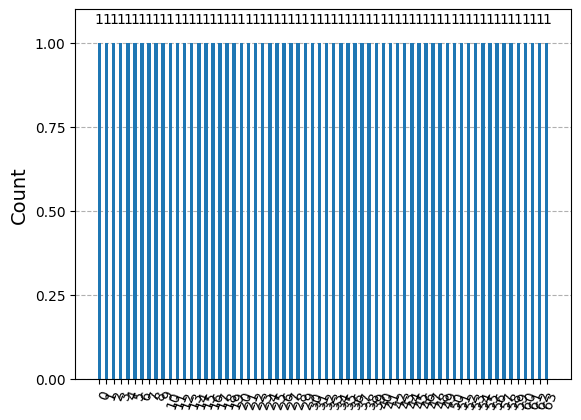

In [2]:
from qiskit.visualization import plot_histogram

plot_histogram(Resultado)